In [1]:
import os
from PIL import Image, ImageOps, ImageChops
import numpy as np
from tensorflow import keras 
import matplotlib.pyplot as plt

In [2]:
#PARAMETERS
SIZE = 100

## Load Data

In [3]:
def loadData(path):
    filelist=os.listdir(path)
    class_list = []
    current_class_counter = 0
    
    all_images = []
    all_labels = []
    
    # Iterate through class folders in path
    for current_class in filelist:
        if current_class[0] == ".":
            continue
        print(current_class)
        class_list.append(current_class)
        class_path = os.listdir(path+"/"+current_class)
        
        # iterate through images in class folders
        for image in class_path:
            if image[0] == ".":
                continue
            #print(image)
            # Bild an all_images anhängen
            temp = Image.open(path+"/"+current_class+"/"+image)
            keep = temp.copy()
            all_images.append(keep)
            temp.close()
            
            # Label an all_labels anhängen
            all_labels.append(current_class_counter)
        
        current_class_counter += 1
        
    print(len(all_images)," images loaded")
        
    return all_images, all_labels, class_list

In [4]:
train_images, train_labels, train_class_list = loadData("Data/train_data")

Bicycle
Bridge
Bus
Car
Chimney
Crosswalk
Hydrant
Motorcycle
Other
Palm
Stair
Traffic Light
2432  images loaded


In [5]:
val_images, val_labels, val_class_list = loadData("Data/val_data")

Bicycle
Bridge
Bus
Car
Chimney
Crosswalk
Hydrant
Motorcycle
Other
Palm
Stair
Traffic Light
542  images loaded


In [6]:
#all_images, all_labels, class_list = loadData("Data/train_val_data")

In [7]:
def checkCorrectnesOfLabels(image_list, label_list, class_list, i):
    print(class_list[label_list[i]])
    display(image_list[i])

Bicycle


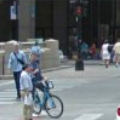

In [8]:
checkCorrectnesOfLabels(train_images, train_labels, train_class_list, 1)

Bicycle


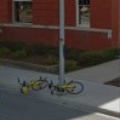

In [9]:
checkCorrectnesOfLabels(val_images, val_labels, val_class_list, 9)

## Get Overview of data

In [10]:
train_images[0].width

120

In [11]:
all_widths = []
all_heights = []
for image in train_images:
    all_widths.append(image.width)
    if image.width == 120:
        all_heights.append(image.height)
        
# -> größe der Bilder immer 100x100 oder 120x120

In [12]:
np.unique(all_widths)

array([100, 120])

## Datenpreprocessing:

In [13]:
def resizeImages(list_images):
    # Daten einheitlich auf 120x120 hochskalieren
    for i in range(len(list_images)):
        if list_images[i].width != SIZE:
            #display(list_images[i])
            new_image = list_images[i].resize((SIZE, SIZE))
            #display(new_image)

            list_images[i] = new_image
    return list_images

In [14]:
train_images_1 = resizeImages(train_images)

In [15]:
val_images_1 = resizeImages(val_images)

In [16]:
def checkFourthValue(list_images):
    # prüfen ob 4. wert immer 255 ist
    min_value = 2300

    for image in list_images:
        np_img = np.array(list_images[0])
        #print(np_img.shape)
        if np_img[:,:,3].min() < min_value:
            min_value = np_img[:,:,3].min()

    print(min_value)

    # -> Wert bei 4. dimension immer 255 -> kann man weglassen

In [17]:
checkFourthValue(train_images)

255


## Convert to np_array

In [18]:
def convertImageToNp(list_images):
    all_np_images = []
    for image in list_images:
        current_image = np.array(image)
        

        # 4. wert bei rgb weg machen
        current_image = current_image[:, :, :3]
        #print(current_image.shape)

        all_np_images.append(current_image)

    return np.array(all_np_images)

In [19]:
train_images_np2 = convertImageToNp(train_images_1)
val_images_np2 = convertImageToNp(val_images_1)

In [20]:
train_images_np2.shape

(2432, 100, 100, 3)

## Convert Label to OneHot

In [21]:
def convertToOneHot(labels):
    all_labels_np = np.array(labels)
    onehot_labels = np.zeros((all_labels_np.size, all_labels_np.max() + 1))
    onehot_labels[np.arange(all_labels_np.size), all_labels_np] = 1
    return onehot_labels

In [22]:
train_labels_oh2 = convertToOneHot(train_labels)

In [23]:
val_labels_oh2 = convertToOneHot(val_labels)

In [24]:
train_labels_oh2

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Splitten in train und val daten

## Build ImageDataGenerator

In [25]:
from keras.preprocessing.image import ImageDataGenerator


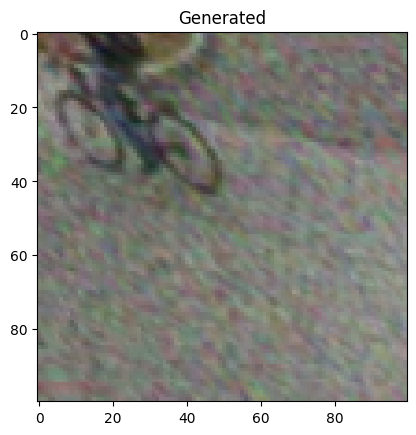

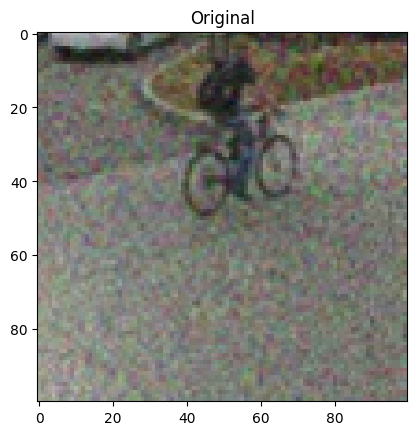

In [26]:
gen = ImageDataGenerator(#rotation_range = 15, 
                         width_shift_range = (-5, 5), 
                         height_shift_range = (-5, 5), 
                         brightness_range = (1, 1.8),# (0.5,1.5), 
                         fill_mode= "reflect",
                         horizontal_flip = True,
                         shear_range=30,
                         zoom_range=[0.8, 1]
                         #validation_split=0.2
                         )


for batch in gen.flow(x = train_images_np2, y = train_labels_oh2, batch_size = 1, shuffle=False):
    
    first_image = Image.fromarray(batch[0][0].astype("uint8"))
    plt.imshow(first_image)
    plt.title("Generated")
    plt.show()
    plt.imshow(train_images_np2[0])
    plt.title("Original")
    plt.show()
    
    break

## Load CNN Model

In [27]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.models import Model
import time
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import math

In [28]:
# ResNet aufbauen
model_input = keras.Input(shape=(SIZE, SIZE, 3))

resnet50 = keras.applications.VGG16(
    weights="imagenet", include_top=False, input_tensor=model_input
)

x1 = Flatten()(resnet50.output)
x2 = Dense(128, activation="relu")(x1)
prediction = Dense(12, activation="softmax")(x2) 

resnet_model = Model(inputs = resnet50.input, outputs = prediction)

In [31]:
# kompilieren
resnet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0004), # oder: , rmsprop
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),# "categorical_crossentropy", # keras.losses.CategoricalCrossentropy(from_logits=True)
              metrics=["accuracy"])  

In [32]:
resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [33]:
MODELNAME = "Versuch5"

# Set distinct name
NAME = MODELNAME+"{}".format(int(time.time()))

# Set filepath
checkpoint_filepath = 'goodModels/{}'.format(NAME)

# set up callback
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy', # val_accuracy
    mode='max',
    save_best_only=True)

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=10), #val_accuracy
    model_checkpoint_callback,
    #tensorboard
]

In [34]:
X_train = train_images_np2
y_train = train_labels_oh2
X_val = val_images_np2
y_val = val_labels_oh2

BATCH_SIZE = 32
history = resnet_model.fit(gen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True), 
                           validation_data=(X_val, y_val),
                           steps_per_epoch=math.ceil(len(X_train)/BATCH_SIZE), 
                           epochs=100, workers=8, callbacks= callbacks)

Epoch 1/100


C:\Users\Jakob\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


75/76 [============================>.] - ETA: 0s - loss: 2.9006 - accuracy: 0.2688

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 11s 68ms/step - loss: 2.8917 - accuracy: 0.2693 - val_loss: 2.1979 - val_accuracy: 0.2915
Epoch 2/100
76/76 [==============================] - 3s 43ms/step - loss: 2.1400 - accuracy: 0.3030 - val_loss: 2.1237 - val_accuracy: 0.2915
Epoch 3/100
75/76 [============================>.] - ETA: 0s - loss: 2.0637 - accuracy: 0.3050

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 5s 58ms/step - loss: 2.0600 - accuracy: 0.3063 - val_loss: 1.9608 - val_accuracy: 0.3395
Epoch 4/100
76/76 [==============================] - 3s 43ms/step - loss: 1.9330 - accuracy: 0.3318 - val_loss: 2.0680 - val_accuracy: 0.3303
Epoch 5/100
75/76 [============================>.] - ETA: 0s - loss: 1.8686 - accuracy: 0.3592

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 56ms/step - loss: 1.8669 - accuracy: 0.3602 - val_loss: 1.8063 - val_accuracy: 0.3764
Epoch 6/100
75/76 [============================>.] - ETA: 0s - loss: 1.8184 - accuracy: 0.3708

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 5s 59ms/step - loss: 1.8193 - accuracy: 0.3701 - val_loss: 1.7658 - val_accuracy: 0.3911
Epoch 7/100
75/76 [============================>.] - ETA: 0s - loss: 1.7259 - accuracy: 0.4038

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 56ms/step - loss: 1.7274 - accuracy: 0.4030 - val_loss: 1.6395 - val_accuracy: 0.4465
Epoch 8/100
76/76 [==============================] - 3s 43ms/step - loss: 1.6969 - accuracy: 0.4104 - val_loss: 1.6152 - val_accuracy: 0.4188
Epoch 9/100
75/76 [============================>.] - ETA: 0s - loss: 1.6329 - accuracy: 0.4325

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 5s 58ms/step - loss: 1.6363 - accuracy: 0.4301 - val_loss: 1.6438 - val_accuracy: 0.4502
Epoch 10/100
75/76 [============================>.] - ETA: 0s - loss: 1.5480 - accuracy: 0.4737

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 57ms/step - loss: 1.5484 - accuracy: 0.4729 - val_loss: 1.5128 - val_accuracy: 0.4723
Epoch 11/100
76/76 [==============================] - 3s 43ms/step - loss: 1.5041 - accuracy: 0.4794 - val_loss: 1.5916 - val_accuracy: 0.4594
Epoch 12/100
75/76 [============================>.] - ETA: 0s - loss: 1.4630 - accuracy: 0.5000

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 58ms/step - loss: 1.4650 - accuracy: 0.4996 - val_loss: 1.4085 - val_accuracy: 0.5240
Epoch 13/100
75/76 [============================>.] - ETA: 0s - loss: 1.3809 - accuracy: 0.5342

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 57ms/step - loss: 1.3792 - accuracy: 0.5354 - val_loss: 1.3522 - val_accuracy: 0.5554
Epoch 14/100
75/76 [============================>.] - ETA: 0s - loss: 1.3164 - accuracy: 0.5450

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 58ms/step - loss: 1.3140 - accuracy: 0.5465 - val_loss: 1.3156 - val_accuracy: 0.5701
Epoch 15/100
75/76 [============================>.] - ETA: 0s - loss: 1.2904 - accuracy: 0.5688

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 57ms/step - loss: 1.2842 - accuracy: 0.5707 - val_loss: 1.1674 - val_accuracy: 0.5978
Epoch 16/100
76/76 [==============================] - 3s 44ms/step - loss: 1.1950 - accuracy: 0.6003 - val_loss: 1.2744 - val_accuracy: 0.5923
Epoch 17/100
75/76 [============================>.] - ETA: 0s - loss: 1.1865 - accuracy: 0.6025

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 58ms/step - loss: 1.1876 - accuracy: 0.6024 - val_loss: 1.1913 - val_accuracy: 0.6273
Epoch 18/100
76/76 [==============================] - 3s 44ms/step - loss: 1.1333 - accuracy: 0.6238 - val_loss: 1.1668 - val_accuracy: 0.6218
Epoch 19/100
76/76 [==============================] - 3s 43ms/step - loss: 1.0746 - accuracy: 0.6386 - val_loss: 1.2200 - val_accuracy: 0.6015
Epoch 20/100
75/76 [============================>.] - ETA: 0s - loss: 1.0685 - accuracy: 0.6458

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 57ms/step - loss: 1.0635 - accuracy: 0.6480 - val_loss: 1.0616 - val_accuracy: 0.6384
Epoch 21/100
75/76 [============================>.] - ETA: 0s - loss: 1.0007 - accuracy: 0.6658

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 57ms/step - loss: 1.0002 - accuracy: 0.6653 - val_loss: 1.1232 - val_accuracy: 0.6439
Epoch 22/100
75/76 [============================>.] - ETA: 0s - loss: 0.9777 - accuracy: 0.6762

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 57ms/step - loss: 0.9751 - accuracy: 0.6768 - val_loss: 1.0461 - val_accuracy: 0.6679
Epoch 23/100
76/76 [==============================] - 3s 44ms/step - loss: 0.9621 - accuracy: 0.6850 - val_loss: 1.0753 - val_accuracy: 0.6568
Epoch 24/100
75/76 [============================>.] - ETA: 0s - loss: 0.9658 - accuracy: 0.6717

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 57ms/step - loss: 0.9645 - accuracy: 0.6702 - val_loss: 0.9955 - val_accuracy: 0.6974
Epoch 25/100
76/76 [==============================] - 3s 43ms/step - loss: 0.8317 - accuracy: 0.7270 - val_loss: 0.9933 - val_accuracy: 0.6900
Epoch 26/100
76/76 [==============================] - 3s 43ms/step - loss: 0.8328 - accuracy: 0.7192 - val_loss: 1.1527 - val_accuracy: 0.6458
Epoch 27/100
76/76 [==============================] - 3s 43ms/step - loss: 0.7764 - accuracy: 0.7299 - val_loss: 0.9947 - val_accuracy: 0.6956
Epoch 28/100
76/76 [==============================] - 3s 43ms/step - loss: 0.8089 - accuracy: 0.7368 - val_loss: 0.9923 - val_accuracy: 0.6827
Epoch 29/100
76/76 [==============================] - 3s 43ms/step - loss: 0.7683 - accuracy: 0.7549 - val_loss: 1.0554 - val_accuracy: 0.6845
Epoch 30/100
75/76 [============================>.] - ETA: 0s - loss: 0.7660 - accuracy: 0.7575

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 57ms/step - loss: 0.7642 - accuracy: 0.7574 - val_loss: 0.8607 - val_accuracy: 0.7325
Epoch 31/100
76/76 [==============================] - 3s 44ms/step - loss: 0.7019 - accuracy: 0.7640 - val_loss: 0.8981 - val_accuracy: 0.7140
Epoch 32/100
76/76 [==============================] - 3s 43ms/step - loss: 0.7448 - accuracy: 0.7545 - val_loss: 0.9415 - val_accuracy: 0.6882
Epoch 33/100
75/76 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.7721

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 58ms/step - loss: 0.6931 - accuracy: 0.7718 - val_loss: 0.8518 - val_accuracy: 0.7343
Epoch 34/100
76/76 [==============================] - 3s 44ms/step - loss: 0.6672 - accuracy: 0.7697 - val_loss: 1.2094 - val_accuracy: 0.6347
Epoch 35/100
76/76 [==============================] - 3s 44ms/step - loss: 0.7036 - accuracy: 0.7677 - val_loss: 0.9761 - val_accuracy: 0.7122
Epoch 36/100
76/76 [==============================] - 3s 44ms/step - loss: 0.6222 - accuracy: 0.7977 - val_loss: 0.9884 - val_accuracy: 0.6882
Epoch 37/100
76/76 [==============================] - 3s 44ms/step - loss: 0.6264 - accuracy: 0.7891 - val_loss: 1.0236 - val_accuracy: 0.6790
Epoch 38/100
76/76 [==============================] - 3s 44ms/step - loss: 0.5736 - accuracy: 0.8100 - val_loss: 0.9539 - val_accuracy: 0.7103
Epoch 39/100
75/76 [============================>.] - ETA: 0s - loss: 0.5403 - accuracy: 0.8183

INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676123347\assets


76/76 [==============================] - 4s 57ms/step - loss: 0.5417 - accuracy: 0.8170 - val_loss: 0.8789 - val_accuracy: 0.7362
Epoch 40/100
76/76 [==============================] - 4s 45ms/step - loss: 0.5969 - accuracy: 0.8076 - val_loss: 0.9585 - val_accuracy: 0.7085
Epoch 41/100
76/76 [==============================] - 3s 44ms/step - loss: 0.5915 - accuracy: 0.8059 - val_loss: 0.9742 - val_accuracy: 0.7011
Epoch 42/100
76/76 [==============================] - 3s 44ms/step - loss: 0.6084 - accuracy: 0.8043 - val_loss: 1.0199 - val_accuracy: 0.6974
Epoch 43/100
76/76 [==============================] - 4s 48ms/step - loss: 0.5728 - accuracy: 0.8125 - val_loss: 1.0266 - val_accuracy: 0.6716
Epoch 44/100
76/76 [==============================] - 3s 44ms/step - loss: 0.4990 - accuracy: 0.8400 - val_loss: 0.9913 - val_accuracy: 0.7085
Epoch 45/100
76/76 [==============================] - 3s 44ms/step - loss: 0.4791 - accuracy: 0.8405 - val_loss: 0.8839 - val_accuracy: 0.7214
Epoch 46/100

## Model nachtrainieren

In [55]:
vgg16_nachtr = keras.models.load_model("goodModels/vgg16_nachtr_7620/")

In [56]:
# kompilieren
vgg16_nachtr.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), # oder: , rmsprop
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),# "categorical_crossentropy", # keras.losses.CategoricalCrossentropy(from_logits=True)
              metrics=["accuracy"])  

In [57]:
MODELNAME_nachtr = "Versuch5"

# Set distinct name
NAME_nachtr = MODELNAME_nachtr+"{}".format(int(time.time()))

# Set filepath
checkpoint_filepath_nachtr = 'goodModels/{}'.format(NAME_nachtr)

# set up callback
model_checkpoint_callback_nachtr = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_nachtr,
    save_weights_only=False,
    monitor='val_accuracy', # val_accuracy
    mode='max',
    save_best_only=True)

callbacks_nachtr = [
    EarlyStopping(monitor="val_accuracy", patience=10), #val_accuracy
    model_checkpoint_callback_nachtr,
    #tensorboard
]

In [58]:
history = vgg16_nachtr.fit(gen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True), 
                           validation_data=(X_val, y_val),
                           steps_per_epoch=math.ceil(len(X_train)/BATCH_SIZE), 
                           epochs=100, workers=8, callbacks= callbacks_nachtr)

Epoch 1/100


C:\Users\Jakob\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


76/76 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 0.9198

INFO:tensorflow:Assets written to: goodModels\Versuch51676126242\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676126242\assets


76/76 [==============================] - 6s 63ms/step - loss: 0.2526 - accuracy: 0.9198 - val_loss: 0.7783 - val_accuracy: 0.7712
Epoch 2/100
75/76 [============================>.] - ETA: 0s - loss: 0.2163 - accuracy: 0.9317

INFO:tensorflow:Assets written to: goodModels\Versuch51676126242\assets


INFO:tensorflow:Assets written to: goodModels\Versuch51676126242\assets


76/76 [==============================] - 5s 60ms/step - loss: 0.2167 - accuracy: 0.9313 - val_loss: 0.7802 - val_accuracy: 0.7823
Epoch 3/100
76/76 [==============================] - 4s 45ms/step - loss: 0.1959 - accuracy: 0.9363 - val_loss: 0.7918 - val_accuracy: 0.7749
Epoch 4/100
76/76 [==============================] - 4s 46ms/step - loss: 0.1847 - accuracy: 0.9465 - val_loss: 0.8006 - val_accuracy: 0.7768
Epoch 5/100
76/76 [==============================] - 4s 45ms/step - loss: 0.1697 - accuracy: 0.9457 - val_loss: 0.8194 - val_accuracy: 0.7786
Epoch 6/100
76/76 [==============================] - 4s 45ms/step - loss: 0.1643 - accuracy: 0.9515 - val_loss: 0.8180 - val_accuracy: 0.7712
Epoch 7/100
76/76 [==============================] - 4s 45ms/step - loss: 0.1684 - accuracy: 0.9494 - val_loss: 0.8354 - val_accuracy: 0.7712
Epoch 8/100
76/76 [==============================] - 4s 45ms/step - loss: 0.1544 - accuracy: 0.9502 - val_loss: 0.8203 - val_accuracy: 0.7823
Epoch 9/100
76/76 

In [ ]:
print("Test: ",vgg16_7239.evaluate(X_val, y_val))

In [ ]:
y_pred = vgg16_7239.predict(X_val)

In [ ]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [ ]:
train_class_list

In [ ]:
def showResult(X, labels, i):
    print(train_class_list[labels[i]])
    display(Image.fromarray(X[i]))

In [ ]:
showResult(X_val, y_pred_labels, 11)

In [ ]:
resnet_model.evaluate(X_val, y_val)

In [ ]:
# Versuch 1: 56,44 % (rmsprop)
# Versuch 2: 0.7311 %  (adam, 0.0005)
# Versuch 3: 0.7311 %  (adam, 0.0003)
0.7057

In [ ]:
# optimizer
# batch size
# datagenerator
# rauschen
# kontrolliertes splitten der Train Val daten, sodass klassen einheitlich repräsentiert sind


In [ ]:
annähernd gleich viele Daten pro Klasse
 - erhöhen oder verringern?
 - händisch die ganz schlimmen aus dem Datensatz rausschmeißen